In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [2]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
# data load
df_name = 'esol'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64


In [4]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [5]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,-0.77
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,-3.30
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,-2.06
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,-7.87
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,1,0,0,-1.33


In [6]:
# 컬럼 순서 변경
# target을 가장 앞으로
cols = df_all_features.columns.tolist()
df_all_features = df_all_features[[cols[-1]] + cols[:-1]]
print(df_all_features)

      target  MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  \
0     -0.770       10.253329       -1.701605          10.253329   
1     -3.300       11.724911       -0.145880          11.724911   
2     -2.060       10.020498        0.845090          10.020498   
3     -7.870        2.270278        1.301055           2.270278   
4     -1.330        2.041667        1.712963           2.041667   
...      ...             ...             ...                ...   
1123  -1.710       10.999421       -4.317901          10.999421   
1124   0.106       11.337508       -0.705457          11.337508   
1125  -3.091        5.174287       -1.984662           5.174287   
1126  -3.180        2.222222        0.884259           2.222222   
1127  -4.522       11.888207       -3.753520          11.888207   

      MinAbsEStateIndex       qed    MolWt  HeavyAtomMolWt  ExactMolWt  \
0              0.486602  0.217518  457.432         430.216  457.158411   
1              0.145880  0.811283  201.225     

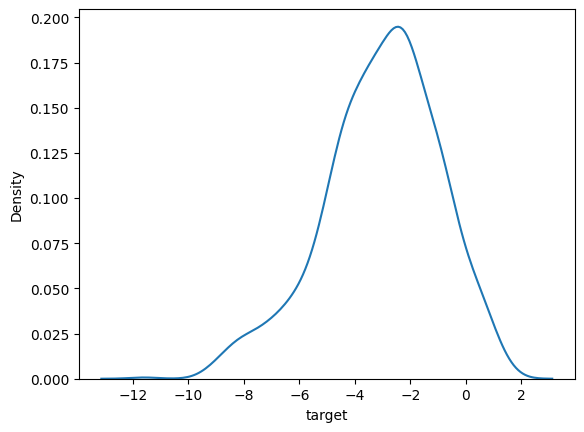

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(df.iloc[:, -1],color='blue', fill = True)
# plt.ylabel('')
sns.kdeplot(df_all_features['target'])
plt.show()


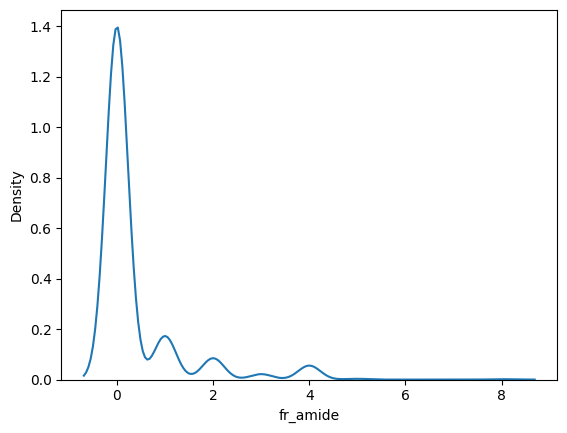

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.kdeplot(df.iloc[:, -1],color='blue', fill = True)
# plt.ylabel('')
sns.kdeplot(df_all_features['fr_amide'])
plt.show()

In [12]:
print(df_all_features['fr_amide'].value_counts())
print(df_all_features['fr_amide'].describe().T)

fr_amide
0    908
1    112
2     55
4     36
3     14
5      2
8      1
Name: count, dtype: int64
count    1128.000000
mean        0.377660
std         0.935885
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: fr_amide, dtype: float64


In [9]:
# 통계량
df_static = df_all_features.describe().T

# overleaf 양식에 맞게 통계량 출력
for i in range(len(df_static)):
    print(f'{df_static.iloc[i].name.replace("_", "")} & {df_static.iloc[i]["mean"]:.2f} & {df_static.iloc[i]["std"]:.2f} & {df_static.iloc[i]["min"]:.2f} & {df_static.iloc[i]["25%"]:.2f} & {df_static.iloc[i]["50%"]:.2f} & {df_static.iloc[i]["75%"]:.2f} & {df_static.iloc[i]["max"]:.2f} \\\\')

target & -3.05 & 2.10 & -11.60 & -4.32 & -2.86 & -1.60 & 1.58 \\
MaxEStateIndex & 8.24 & 3.71 & 0.00 & 5.05 & 9.19 & 11.48 & 17.26 \\
MinEStateIndex & -0.18 & 1.29 & -5.57 & -0.61 & -0.05 & 0.74 & 4.00 \\
MaxAbsEStateIndex & 8.24 & 3.71 & 0.00 & 5.05 & 9.19 & 11.48 & 17.26 \\
MinAbsEStateIndex & 0.49 & 0.49 & 0.00 & 0.11 & 0.31 & 0.79 & 4.00 \\
qed & 0.55 & 0.15 & 0.15 & 0.45 & 0.53 & 0.65 & 0.93 \\
MolWt & 203.94 & 102.74 & 16.04 & 121.18 & 182.18 & 270.37 & 780.95 \\
HeavyAtomMolWt & 191.49 & 99.32 & 12.01 & 112.09 & 172.10 & 256.66 & 716.44 \\
ExactMolWt & 203.46 & 102.40 & 16.03 & 121.09 & 182.08 & 270.16 & 780.43 \\
NumValenceElectrons & 72.06 & 36.15 & 8.00 & 44.00 & 64.00 & 94.00 & 312.00 \\
NumRadicalElectrons & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
MaxPartialCharge & 0.17 & 0.14 & -0.12 & 0.05 & 0.16 & 0.30 & 0.65 \\
MinPartialCharge & -0.30 & 0.15 & -0.75 & -0.41 & -0.34 & -0.12 & -0.04 \\
MaxAbsPartialCharge & 0.31 & 0.15 & 0.04 & 0.14 & 0.35 & 0.43 & 0.75 \\
Min

In [10]:
# # 시각화
# # 밀도 함수
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.kdeplot(df.iloc[:, -1],color='blue', fill = True)
# plt.ylabel('')

# plt.savefig(f'density_{df_name}.png', dpi = 300, bbox_inches = 'tight')
# plt.show()

In [11]:
# # 박스플랏
# plt.boxplot(df.iloc[:, -1],  vert=False)

# plt.savefig(f'boxplot_{df_name}.png', dpi = 300, bbox_inches = 'tight')
# plt.show()